In [1]:
import math
import pandas as pd
import calendar

def compute_et0_fao56(row, altitude=900):
    """
    Compute the reference evapotranspiration (ET₀) using the FAO Penman-Monteith equation.

    Parameters:
        row: A pandas Series with the following keys:
            - T2M_MIN: Daily minimum temperature (°C)
            - T2M_MAX: Daily maximum temperature (°C)
            - RH2M: Relative Humidity at 2 m (%)
            - WS2M: Wind speed at 2 m (m/s)
            - ALLSKY_SFC_SW_DWN: All-sky surface shortwave downward irradiance (kWh/m²/day)
        altitude: Elevation in meters (default 900 m)

    Returns:
        ET₀ in mm/day (rounded to 3 decimal places).
    """
    tmin = row['T2M_MIN']
    tmax = row['T2M_MAX']
    tmean = (tmin + tmax) / 2
    rh = row['RH2M']
    wind = row['WS2M']
    rs_kwh = row['ALLSKY_SFC_SW_DWN']

    # Convert solar radiation from kWh/m²/day to MJ/m²/day
    rs = rs_kwh * 3.6

    # Calculate saturation vapor pressure from Tmin and Tmax
    es_tmin = 0.6108 * math.exp((17.27 * tmin) / (tmin + 237.3))
    es_tmax = 0.6108 * math.exp((17.27 * tmax) / (tmax + 237.3))
    es = (es_tmin + es_tmax) / 2

    # Calculate actual vapor pressure (ea) using RH2M
    ea = es * (rh / 100)

    # Calculate slope of the saturation vapor pressure curve (Δ)
    delta = 4098 * (0.6108 * math.exp((17.27 * tmean) / (tmean + 237.3))) / ((tmean + 237.3) ** 2)

    # Estimate atmospheric pressure (P) using the altitude (in meters)
    p = 101.3 * (((293 - 0.0065 * altitude) / 293) ** 5.26)

    # Calculate psychrometric constant (γ)
    gamma = 0.000665 * p

    # Net radiation (Rn), approximated using shortwave radiation data and albedo of 0.23
    albedo = 0.23
    rn = rs * (1 - albedo)

    # Soil heat flux G is assumed to be 0 for daily calculations
    G = 0

    # Compute ET0 using the FAO Penman-Monteith equation
    numerator = (0.408 * delta * (rn - G)) + (gamma * (900 / (tmean + 273)) * wind * (es - ea))
    denominator = delta + gamma * (1 + 0.34 * wind)
    et0 = numerator / denominator

    return round(et0, 3)

# Read the input CSV file (adjust the file name/path as needed)
input_csv = 'POWER_Point_Daily_19900101_20241231_013d02N_077d56E_LST.csv'# Make sure this file contains columns: T2M_MIN, T2M_MAX, RH2M, WS2M, ALLSKY_SFC_SW_DWN
df = pd.read_csv(input_csv)

# Apply the ET₀ calculation to each row of the DataFrame
df['ET0'] = df.apply(lambda row: compute_et0_fao56(row, altitude=900), axis=1)
df['ALLSKY_SFC_SW_DWN'] = df['ALLSKY_SFC_SW_DWN'] * 3.6
# df["MO"] = df["MO"].apply(lambda x: calendar.month_abbr[int(x)])

# Save the DataFrame with the computed ET0 column to an output CSV file
output_csv = 'output_data_with_ET0.csv'
df.to_csv(output_csv, index=False)

print("Output CSV generated:", output_csv)


Output CSV generated: output_data_with_ET0.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
df = pd.read_csv('output_data_with_ET0.csv')
df.tail()
df.shape

(12784, 9)

In [4]:
def remove_outliers_iqr(df, features):
    cleaned_df = df.copy()
    for feature in features:
        Q1 = cleaned_df[feature].quantile(0.25)
        Q3 = cleaned_df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        cleaned_df = cleaned_df[(cleaned_df[feature] >= lower) & (cleaned_df[feature] <= upper)]
        print(f"Removed {len(df) - len(cleaned_df)} outliers from {feature}")
    return cleaned_df
features = ['T2M_MIN', 'T2M_MAX', 'RH2M', 'WS2M', 'ALLSKY_SFC_SW_DWN', 'ET0']
df_cleaned= remove_outliers_iqr(df, features)
df_cleaned.shape

Removed 344 outliers from T2M_MIN
Removed 344 outliers from T2M_MAX
Removed 351 outliers from RH2M
Removed 638 outliers from WS2M
Removed 725 outliers from ALLSKY_SFC_SW_DWN
Removed 747 outliers from ET0


(12037, 9)

In [5]:
# !pip install -U ydata_profiling

# import ydata_profiling
# import pandas as pd # Import pandas for reading the CSV

# # Load the data into a DataFrame named 'output_data_with_ET0'
# output_data_with_ET0 = pd.read_csv('output_data_with_ET0.csv')

# from ydata_profiling.utils.cache import cache_file

# report = df_cleaned.profile_report(sort=None, html={"style": {"full_width": True}}, progress_bar=False)
# report

# profile_report = df_cleaned.profile_report(html={"style": {"full_width": True}})
# profile_report.to_file("example.html")

# profile_report = df_cleaned.profile_report(
#     explorative=True, html={"style": {"full_width": True}})
# profile_report

<Axes: >

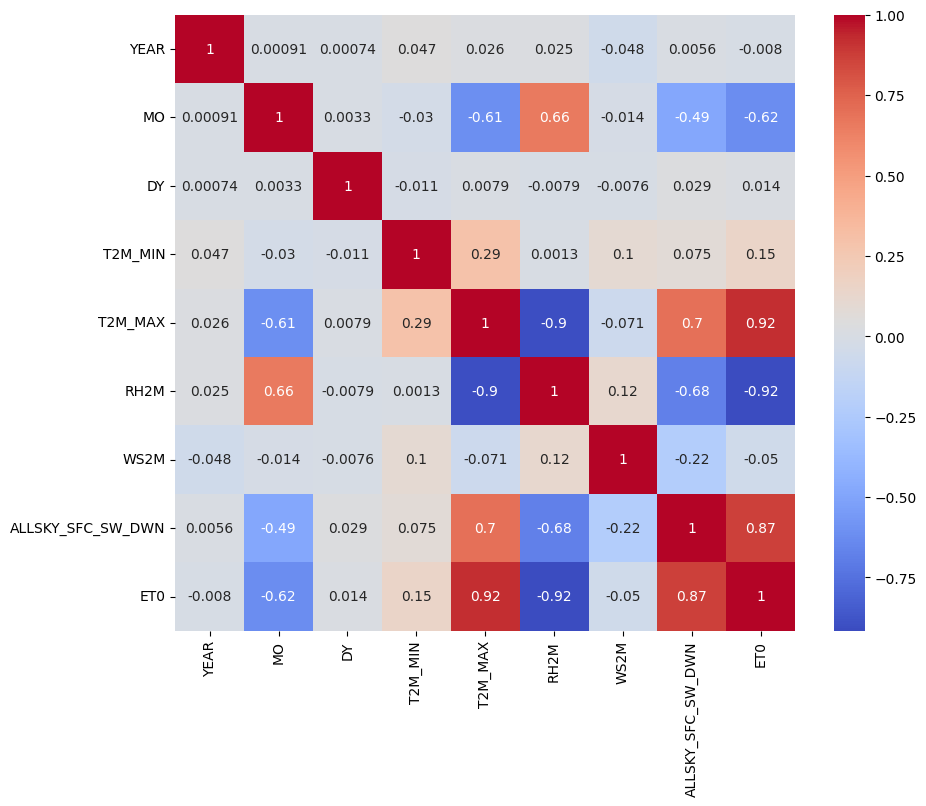

In [6]:
df_cleaned.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(df_cleaned.corr(), annot=True, cmap='coolwarm')

In [7]:
df_cleaned.drop(columns=['YEAR', 'DY', 'MO'], inplace=True)
df_cleaned.head()

,T2M_MIN,T2M_MAX,RH2M,WS2M,ALLSKY_SFC_SW_DWN,ET0
0,18.38,29.09,74.63,1.90,16.092,4.215
1,18.03,28.98,71.75,2.92,14.184,4.193
2,16.87,29.04,70.53,3.29,20.340,5.417
3,15.81,28.57,68.25,3.75,20.304,5.540
4,12.58,27.06,66.94,3.54,19.620,5.173


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_cleaned.drop(columns=['ET0']), df_cleaned['ET0'], test_size=0.2, random_state=42)

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

In [10]:
model_LR = LinearRegression()
model_LR.fit(X_train, y_train)
y_pred_LR = model_LR.predict(X_test)
mse_LR = mean_squared_error(y_test, y_pred_LR)
r2_LR = r2_score(y_test, y_pred_LR)
print("Linear Regression MSE:", mse_LR)
print("Linear Regression R2:", r2_LR)

Linear Regression MSE: 0.06254167698679566
Linear Regression R2: 0.9803481071165747


In [25]:
top_3_indices = np.argpartition(np.abs(model_LR.coef_), -3)[-3:]
best_features = X_train.columns[top_3_indices]
print("Best Features:", best_features)

Best Features: Index(['T2M_MAX', 'WS2M', 'ALLSKY_SFC_SW_DWN'], dtype='object')


In [26]:
df_new = df_cleaned[best_features]
df_new['ET0'] = df_cleaned['ET0']
df_new.head()

<ipython-input-26-d911b0939581>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['ET0'] = df_cleaned['ET0']


,T2M_MAX,WS2M,ALLSKY_SFC_SW_DWN,ET0
0,29.09,1.90,16.092,4.215
1,28.98,2.92,14.184,4.193
2,29.04,3.29,20.340,5.417
3,28.57,3.75,20.304,5.540
4,27.06,3.54,19.620,5.173


In [27]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(df_new.drop(columns=['ET0']), df_new['ET0'], test_size=0.2, random_state=42)

In [29]:
from sklearn.ensemble import RandomForestRegressor

Model_RF_df_new = RandomForestRegressor(n_estimators=10, max_depth=5, random_state=42)
Model_RF_df_new.fit(X_train1, y_train1)
y_pred_RF = Model_RF_df_new.predict(X_test1)
mse_RF = mean_squared_error(y_test1, y_pred_RF)
r2_RF = r2_score(y_test1, y_pred_RF)
print("Random Forest Regressor MSE:", mse_RF)
print("Random Forest Regressor R2:", r2_RF)

Random Forest Regressor MSE: 0.14088157197477855
Random Forest Regressor R2: 0.9557320862649488


In [30]:
cross_val_rf = cross_val_score(Model_RF_df_new, X_train1, y_train1, cv=10, scoring='r2')
print("Cross-Validation R2 Scores:", cross_val_rf)
mean = cross_val_rf.mean()
print("Mean R2 Score:", mean)

Cross-Validation R2 Scores: [0.95419772 0.94728313 0.95358597 0.95036637 0.95032596 0.95404321
 0.9533674  0.94710609 0.95478985 0.95033415]
Mean R2 Score: 0.9515399869304761


In [31]:
!pip install m2cgen

In [32]:
import m2cgen as m2c

model_code = m2c.export_to_python(Model_RF_df_new)

with open("rf_model.py", "w") as f:
    f.write(model_code)

In [33]:
def totol_amouth_area_needed_to_irrigate(no_of_plants, plant_spacing, row_spacing, wetting_percentage=100): # spacing in cm
  area_of_one_plant = (plant_spacing * row_spacing) / 10000
  total_area_needed = area_of_one_plant * no_of_plants
  wetting_area = total_area_needed * (wetting_percentage / 100)
  return wetting_area   #area in m_2

In [34]:
import datetime

# ----------------------------
# Crop-specific calibration data
# ----------------------------
# Crop Kc profiles (days after planting, Kc value)
crop_kc_profile = {
    'onion': [
        (0, 0.7),    # At planting: initial low canopy
        (15, 0.7),   # Maintaining initial value until day 20
        (21, 0.8),   # Rapid canopy development
        (24, 0.9),   # Peak canopy development
        (29, 0.94),
        (33, 1),      # Decline as crop nears maturity
        (82, 1.1),
        (106, 0.8)
    ],
    'maize': [
        (0, 0.3),
        (20, 0.3),
        (40, 0.7),
        (60, 1.0),
        (80, 0.8),
        (100, 0.6)
    ]
}

# Crop root zone depth profiles (days after planting, root depth in meters)
crop_root_depth_profile = {
    'onion': [
        (0, 0.05),    # At planting
        (18, 0.25),   # Shallow roots during early establishment
        (38, 0.43),   # Gradual expansion of the root zone
        (73, 0.60),   # Further growth
        (106, 0.60)    # Effective saturation (for onions, root expansion is limited)
    ],
    'maize': [
        (0, 0.30),    # At planting
        (20, 0.50),   # Early root development
        (40, 0.80),   # Increasing root depth
        (60, 1.2),    # Rapid expansion phase
        (80, 1.5)     # Maximum effective root zone
    ]
}

# ----------------------------
# Helper functions
# ----------------------------

def get_days_after_planting(planting_date):
    """
    Calculate the number of days since planting.

    Parameters:
      planting_date: datetime.date representing planting date.

    Returns:
      int: Days elapsed since planting.
    """
    today = datetime.date.today()
    return (today - planting_date).days

def linear_interpolate(days, profile):
    """
    Interpolate a value linearly from a given profile based on days.

    Parameters:
      days (float): Current days after planting.
      profile (list): List of (day, value) tuples sorted by day.

    Returns:
      float: Interpolated value.
    """
    # If days is before the first entry, return the first value.
    if days <= profile[0][0]:
        return profile[0][1]
    # If days is beyond the last entry, return the last value.
    if days >= profile[-1][0]:
        return profile[-1][1]

    # Find the two profile points between which 'days' lies.
    for (d0, v0), (d1, v1) in zip(profile, profile[1:]):
        if d0 <= days <= d1:
            fraction = (days - d0) / (d1 - d0)
            return round(v0 + fraction * (v1 - v0), 3)
    # Fallback – should not be reached
    return profile[-1][1]

def get_daily_kc(crop, planting_date):
    """
    Get the daily crop coefficient (Kc) for a given crop and planting date.

    Parameters:
      crop (str): Crop name (e.g., 'onion', 'maize').
      planting_date (datetime.date): Planting date.

    Returns:
      tuple: (Kc value as float, days after planting as int)
    """
    crop = crop.lower()
    if crop not in crop_kc_profile:
        raise ValueError(f"Crop '{crop}' is not supported in Kc profile. Please add its data.")

    days_after_planting = get_days_after_planting(planting_date)
    profile = crop_kc_profile[crop]
    kc = linear_interpolate(days_after_planting, profile)
    return kc, days_after_planting

def get_daily_root_zone_depth(crop, planting_date):
    """
    Calculate the effective root zone depth for a given crop and planting date.

    Parameters:
      crop (str): Crop name (e.g., 'onion', 'maize').
      planting_date (datetime.date): Planting date.

    Returns:
      tuple: (Root zone depth in millimeters, days after planting as int)
    """
    crop = crop.lower()
    if crop not in crop_root_depth_profile:
        raise ValueError(f"Crop '{crop}' is not supported in root zone depth profile. Please add its data.")

    days_after_planting = get_days_after_planting(planting_date)
    profile = crop_root_depth_profile[crop]
    # Interpolate value in meters then convert to millimeters.
    root_depth_m = linear_interpolate(days_after_planting, profile)
    root_depth_mm = round(root_depth_m * 1000, 1)
    return root_depth_mm, days_after_planting  # root_deepth in mm


# ----------------------------
# Integrated Interface Function
# ----------------------------

def daily_plant_info_interface():
    """
    Interface to input crop type and planting date once,
    then compute daily Kc and root zone depth based on internal dynamic calculations.
    """
    crop = input("Enter crop type (e.g., onion, maize): ").strip().lower()
    planting_date_str = input("Enter planting date (YYYY-MM-DD): ").strip()

    try:
        planting_date = datetime.date.fromisoformat(planting_date_str)
    except ValueError:
        print("Invalid date format. Please use YYYY-MM-DD.")
        return

    # Get daily Kc and root zone depth.
    kc, days_kc = get_daily_kc(crop, planting_date)
    root_depth_mm, days_root = get_daily_root_zone_depth(crop, planting_date)

    # Ideally days_kc and days_root are the same.
    print(f"\nDays after planting: {days_kc}")
    print(f"Estimated daily crop coefficient (Kc) for {crop}: {kc}")
    print(f"Estimated effective root zone depth for {crop}: {root_depth_mm} mm")
    return kc, root_depth_mm

# Function to convert soil moisture (%) to available water depth (mm) in the root zone

def soil_moisture_to_available_depth(root_depth_mm, sensor_vwc_percent=20,
                                     fc_percent=42.32,
                                     pwp_percent=19.0):
    """
    Convert volumetric soil moisture (%) to water available depth (mm) in the root zone.

    Args:
      sensor_vwc_percent (float): Soil moisture reading in % volumetric water content.
      root_zone_depth_mm (float): Effective root zone depth in mm.
      fc_percent (float): Field capacity as a percentage (default: 35.27%).
      pwp_percent (float): Permanent wilting point as a percentage (default: 19.0%).

    Returns:
      float: Depth of water (mm) available to the crop, clipped between 0 and maximum available.
    """
    # Convert percentages to fractions
    sensor_vwc = sensor_vwc_percent / 100.0
    fc = fc_percent / 100.0
    pwp = pwp_percent / 100.0

    # Compute fraction of water above PWP
    available_frac = sensor_vwc - pwp

    # Clip to [0, fc - pwp]
    max_frac = max(0.00001, fc - pwp)
    available_frac = max(0.000001, min(available_frac, max_frac))

    # Convert fraction to water depth (mm)
    water_available_mm = available_frac * root_depth_mm
    return water_available_mm

def totol_time_of_pumping( Kc, water_available_mm, flow_rate=(2.512/100000), ET0=10, wetting_area=16):
  ETc = ET0 * Kc
  required_depth_of_water_needed = (ETc - water_available_mm)
  if required_depth_of_water_needed < 0:
    required_depth_of_water_needed = 0
  else :
    required_depth_of_water_needed = required_depth_of_water_needed

  totol_volume_of_irrigation = required_depth_of_water_needed * wetting_area / 1000 # depth is in meter and area is in meter_2
  totol_time_of_pumping = totol_volume_of_irrigation / flow_rate # flow rate in meter_3 per second (2.512 /100000)***

  return totol_time_of_pumping # totoal time in second


if __name__ == "__main__":
    kc, root_depth_mm = daily_plant_info_interface()


    water_available_mm = soil_moisture_to_available_depth(root_depth_mm)
    print(f"Water available at the crop: {water_available_mm} mm")
    totol_time_of_pumping = totol_time_of_pumping(kc, water_available_mm)
    print(f"Total time of pumping: {totol_time_of_pumping} seconds")

Enter crop type (e.g., onion, maize): onion
Enter planting date (YYYY-MM-DD): 2025-04-03

Days after planting: 27
Estimated daily crop coefficient (Kc) for onion: 0.924
Estimated effective root zone depth for onion: 331.0 mm
Water available at the crop: 3.310000000000003 mm
Total time of pumping: 3777.0700636942656 seconds
